In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras import layers, Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset_dir = '/content/drive/MyDrive/CAPSTONE/ML/fix'
train_data_dir = '/content/drive/MyDrive/CAPSTONE/ML/Dataset3/train'
validation_data_dir = '/content/drive/MyDrive/CAPSTONE/ML/Dataset3/validation'
model_save_path = '/content/drive/MyDrive/CAPSTONE/ML/Model/coba_model.h5'

# if not os.path.exists(dataset_dir):
#     raise FileNotFoundError(f"Dataset directory {dataset_dir} does not exist.")

os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

### ImageDataGenerator untuk Data Augmentasi

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

### Generator untuk Data Training dan Validasi

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1832 images belonging to 5 classes.
Found 242 images belonging to 5 classes.


In [ ]:
print(f"Class indices: {train_generator.class_indices}")

Class indices: {'Bawal Putih': 0, 'Nila': 1, 'Pari': 2, 'Tongkol': 3, 'Tuna': 4}


In [ ]:
train_samples = train_generator.samples
validation_samples = validation_generator.samples
batch_size = train_generator.batch_size

steps_per_epoch = max(train_samples // batch_size, 1)
validation_steps = max(validation_samples // batch_size, 1)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 57
Validation steps: 7


### Build model

In [ ]:
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

for layer in base_model.layers[-8:]:
    layer.trainable = True

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(train_generator.num_classes, activation='softmax')
# ])

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Unfreeze the top layers of the model
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Add new layers
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(base_model.input, output)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

### Train Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
57/57 [==============================] - 561s 10s/step - loss: 3.9831 - accuracy: 0.7272 - val_loss: 0.5467 - val_accuracy: 0.8304 - lr: 1.0000e-04
Epoch 2/15
57/57 [==============================] - 354s 6s/step - loss: 0.4119 - accuracy: 0.8983 - val_loss: 0.3874 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/15
57/57 [==============================] - 348s 6s/step - loss: 0.3363 - accuracy: 0.9233 - val_loss: 0.5167 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 4/15
57/57 [==============================] - 345s 6s/step - loss: 0.2791 - accuracy: 0.9306 - val_loss: 0.2694 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 5/15
57/57 [==============================] - 330s 6s/step - loss: 0.1767 - accuracy: 0.9533 - val_loss: 0.2685 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 6/15
57/57 [==============================] - 339s 6s/step - loss: 0.1638 - accuracy: 0.9572 - val_loss: 1.4246 - val_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 7/15
57/57 [==============================] -

In [ ]:
model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save(model_save_path)

loss, accuracy = model.evaluate(validation_generator)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

8/8 [==============================] - 43s 5s/step - loss: 0.1930 - accuracy: 0.9587
Validation loss: 0.19296586513519287
Validation accuracy: 0.9586777091026306


1/1 [==============================] - 5s 5s/step


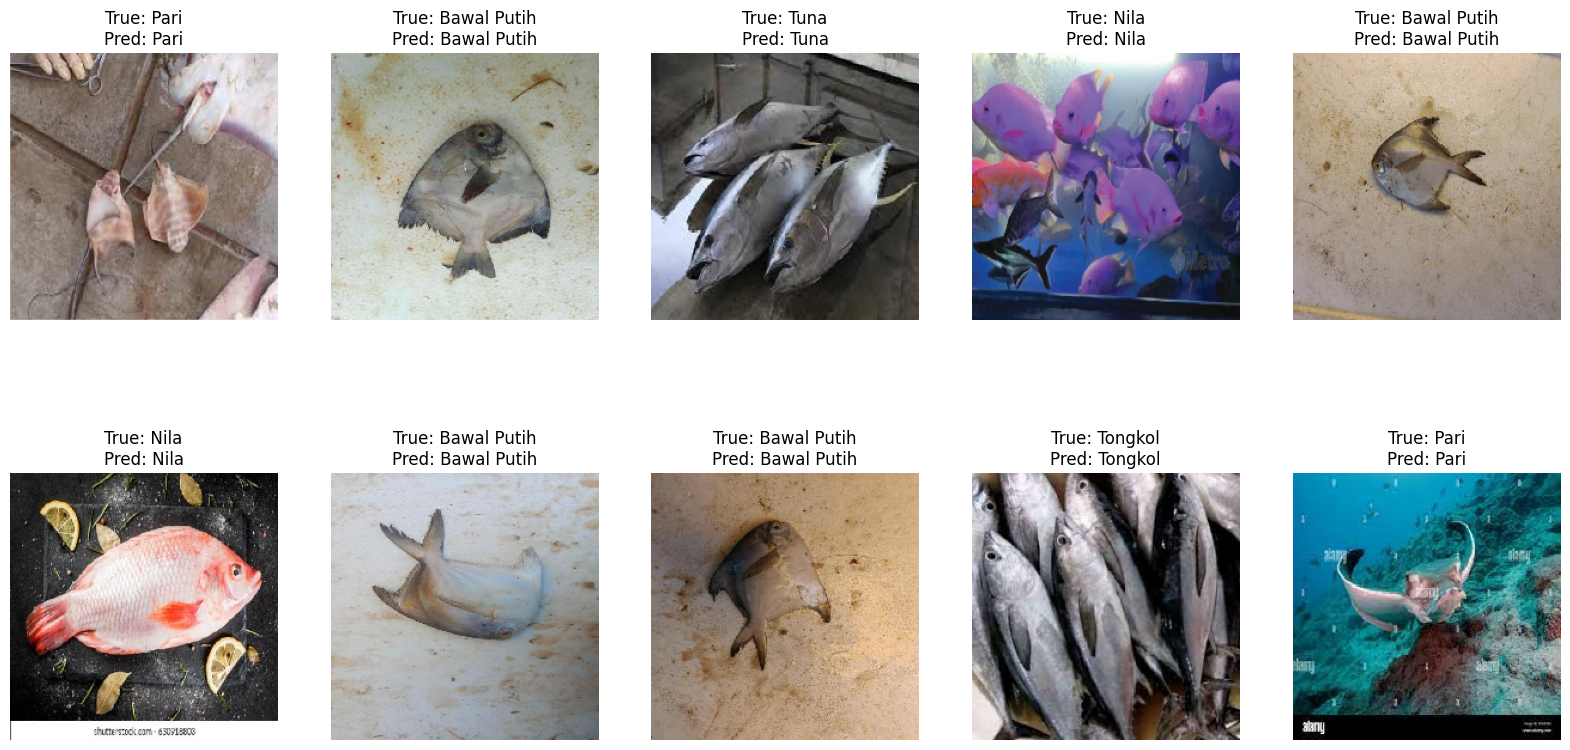

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

validation_images, validation_labels = next(validation_generator)

predictions = model.predict(validation_images)

num_images = min(10, len(validation_images))

plt.figure(figsize=(20, 10))
for i in range(num_images):
    ax = plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(validation_images[i])

    true_label_index = np.argmax(validation_labels[i])
    predicted_label_index = np.argmax(predictions[i])

    true_label = index_to_class[true_label_index]
    predicted_label = index_to_class[predicted_label_index]

    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")

plt.show()

In [ ]:
import os
from PIL import Image
import numpy as np

def average_image_resolution(directory):
    widths = []
    heights = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff', 'gif')):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)

    avg_width = np.mean(widths)
    avg_height = np.mean(heights)

    return avg_width, avg_height

dataset_dir = '/content/drive/MyDrive/CAPSTONE/ML/Dataset3'
avg_width, avg_height = average_image_resolution(dataset_dir)

print(f"Average Width: {avg_width}")
print(f"Average Height: {avg_height}")


Average Width: nan
Average Height: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Manual Testing

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# from PIL import Image
# import numpy as np

# for filename in uploaded.keys():
#     image = Image.open(filename)
#     image = image.resize((224, 224))
#     image = np.array(image) / 255.0
#     image = np.expand_dims(image, axis=0)

In [ ]:
# from tensorflow.keras.models import load_model

# model_path = '/content/drive/MyDrive/CAPSTONE/ML/Model/ikan_model.h5'
# model = load_model(model_path)

In [ ]:
# predictions = model.predict(image)
# predicted_class = np.argmax(predictions, axis=1)

In [ ]:
# class_indices = train_generator.class_indices
# class_map = {v: k for k, v in class_indices.items()}

In [ ]:
# print(f'Predicted class index: {predicted_class[0]}')
# print(f'Predicted class name: {class_map[predicted_class[0]]}')